# Cliff Waking<br>
<font size= +1>
<p style="text-align: justify">
El problema _Cliff Walking_ consiste en que se tiene una cadrícula por la cual te puedes desplazar en cuatro direcciones, una celda a la vez. Las acciones que puedes tomar son __"up"__, __"down"__, __"left"__, __"right"__. 
El objetivo es llegar a una celda en especial que será la meta y como es de pensarse, lo más rapido posible, partiendo de una celda. Toda una sección de esta cuadrícula tiene una pérdida mucho más grande que las demás celdas, por lo que se evitará pasar por esa parte para llegar a la meta.
</p>


In [204]:
using Plots
using NBInclude
@nbinclude("../algoritmos_reforzamiento.ipynb")


q_learning (generic function with 1 method)

In [57]:
struct CWs<: Estado
    x ::Int64 # posición en el eje horizontal
    y ::Int64 # posición en el eje vertical
end

In [58]:
struct CWa <:Accion
    a
    function CWa(a)
        if a!=:up && a!=:down && a!=:left && a!=:right
            error("acción inválida")
        else new(a)
        end
    end
end

In [59]:
struct CW <:MDP
    rows ::Int64
    columns ::Int64
    goal::CWs #Tuple{Int64,Int64}
    start::CWs #Tuple{Int64,Int64}
    redSection::NTuple{4,Int64}
    actions::Array{CWa,1}
    states::Array{CWs,1}
end

In [181]:
function step(mdp::CW,s::CWs, a::CWa)
    """
    if (a.a == :down && s.x == 3 && 2 <= s.y <= 11) || (
        a.a == :right && s == mdp.start)
        return mdp.start
    end
    """
    if (a.a == :down && mdp.redSection[3]<=s.y<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x+1<=mdp.redSection[2])||
        (a.a == :up && mdp.redSection[3]<=s.y<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x-1<=mdp.redSection[2])||
        (a.a == :right && mdp.redSection[3]<=s.y+1<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x<=mdp.redSection[2])||
        (a.a == :left && mdp.redSection[3]<=s.y-1<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x<=mdp.redSection[2])
        return mdp.start
    end
    
    
    if a.a == :up
        return  CWs(max(s.x - 1, 1), s.y)
    elseif a.a == :left
        return  CWs(s.x, max(s.y - 1, 1))
    elseif a.a == :right
        return  CWs(s.x, min(s.y + 1, mdp.columns))
    elseif a.a == :down
        return CWs(min(s.x + 1, mdp.rows), s.y)
    end
end

step (generic function with 1 method)

In [182]:
#terminal
function terminal(modelo::CW,s::CWs)
    s.x==modelo.goal.x && s.y==modelo.goal.y
end

function aLegales(mdp::CW,s::CWs)
    
    acciones=[]
    #push!(acciones,r_accion(mdp))
    #pop!(acciones)
    if s.y > 1
        push!(acciones,CWa(:left))
    end
    if s.y<mdp.columns
        push!(acciones,CWa(:right))
    end
    if s.x >1
        push!(acciones,CWa(:up))
    end
    if s.x<mdp.rows
        push!(acciones,CWa(:down))
    end

    acciones
end

aLegales (generic function with 1 method)

In [206]:
function r(mdp::CW,s::CWs,a::CWa,s2::CWs)

    if terminal(mdp,s) return r(mdp,s) end
    """
    println(s,a)
    if (a.a == :down && s.x == 3 && 2 <= s.y <= 11) || (
        a.a == :right && s == mdp.start)
        println("X")
        return -100
    end
    """
    if (a.a == :down && mdp.redSection[3]<=s.y<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x+1<=mdp.redSection[2])||
        (a.a == :up && mdp.redSection[3]<=s.y<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x-1<=mdp.redSection[2])||
        (a.a == :right && mdp.redSection[3]<=s.y+1<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x<=mdp.redSection[2])||
        (a.a == :left && mdp.redSection[3]<=s.y-1<=mdp.redSection[4] &&  mdp.redSection[1]<=s.x<=mdp.redSection[2])
        return -100
    end
    
        
    -1

end
    
function r(mdp::CW,s::CWs)
        -1
end

r (generic function with 2 methods)

In [207]:
function print_policy(mdp::CW,π_, titulo::String)
    
        optimal_policy = []

        for i in 1:mdp.rows
            push!(optimal_policy,[])
            for j in 1:mdp.columns
                s=CWs(i,j)
                if s==mdp.goal 
                    push!(optimal_policy[i],'G')
                    continue 
                end
                if mdp.redSection[3]<=j<=mdp.redSection[4] && 
                    mdp.redSection[1]<=i<=mdp.redSection[2]
                    push!(optimal_policy[i],'X')
                    continue
                end
                if π_[s].a==:up
                    push!(optimal_policy[i],'U')
                elseif π_[s].a==:down
                    push!(optimal_policy[i],'D')
                elseif π_[s].a==:right
                    push!(optimal_policy[i],'R')
                elseif π_[s].a==:left
                    push!(optimal_policy[i],'L')
                end
            end
        end


        println("Optimal policy for $titulo is:")
        for row in optimal_policy
            println(row)
        end
end

print_policy (generic function with 2 methods)

In [208]:
function figure_6_4(mdp::CW,episodes,ϵ,α,γ, runs)
    
    q_value=Dict((mdp.start,rand(mdp.actions))=>0.0 )
    for s ∈ mdp.states
        for a ∈ aLegales(mdp,s)
        q_value[(s,a)]=0.0
        end
    end
    #q_value = Dict( (s,a)=> 0 for s in mdp.states, a in aLegales(s))
    
    π_1,steps1,rewards1 = expected_sarsa(mdp, q_value, mdp.start, ϵ, α,γ, episodes, false, runs)
    
    print_policy(mdp,π_1, "Ex-Sarsa")
    
    π_2,steps2,rewards2 = q_learning(mdp, q_value, mdp.start, ϵ, α, γ, episodes, false, runs)

    print_policy(mdp,π_2, "Q-Learning")    
    

    Plots.plot(rewards1, label="Sarsa")
    Plots.plot!(rewards2, label="Q-Learning")
    Plots.xaxis!("Episodes")
    Plots.yaxis!("Sum of rewards during episode")
    Plots.ylims!(-100,-0)

end


figure_6_4 (generic function with 2 methods)

In [209]:
# world height
HEIGHT = 4
# world width
WIDTH = 12
# probability for exploration
EPSILON = 0.1
# step size
ALPHA = 0.5
# gamma for Q-Learning and Expected Sarsa
GAMMA = 1.0

ACTIONS = [CWa(:up), CWa(:down), CWa(:left), CWa(:right)]

# initial state action pair values
START = CWs(4, 1)
GOAL = CWs(4, 12)
RED_SECTION=(4,4,2,11) #del renglon 4 al renglon 4 y de la columna 2 a la columna 9

episodes= 500


500

In [210]:
STATES=[]
for i in 1:HEIGHT,j in 1:WIDTH
    #if !( RED_SECTION[3]<=j<=RED_SECTION[4] &&  RED_SECTION[1]<=i<=RED_SECTION[2])
    if !( RED_SECTION[3]<=j<=RED_SECTION[4] &&  RED_SECTION[1]<=i<=RED_SECTION[2])
        push!(STATES,CWs(i,j))
    end
end

mdp=CW(HEIGHT,WIDTH,GOAL,START,RED_SECTION,ACTIONS,STATES)

CW(4, 12, CWs(4, 12), CWs(4, 1), (4, 4, 2, 11), CWa[CWa(:up), CWa(:down), CWa(:left), CWa(:right)], CWs[CWs(1, 1), CWs(1, 2), CWs(1, 3), CWs(1, 4), CWs(1, 5), CWs(1, 6), CWs(1, 7), CWs(1, 8), CWs(1, 9), CWs(1, 10)  …  CWs(3, 5), CWs(3, 6), CWs(3, 7), CWs(3, 8), CWs(3, 9), CWs(3, 10), CWs(3, 11), CWs(3, 12), CWs(4, 1), CWs(4, 12)])

Optimal policy for Ex-Sarsa is:
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'R', 'D']
Any['U', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'G']
Optimal policy for Q-Learning is:
Any['R', 'R', 'R', 'R', 'R', 'R', 'D', 'D', 'D', 'R', 'D', 'D']
Any['R', 'R', 'D', 'R', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
Any['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
Any['U', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'G']


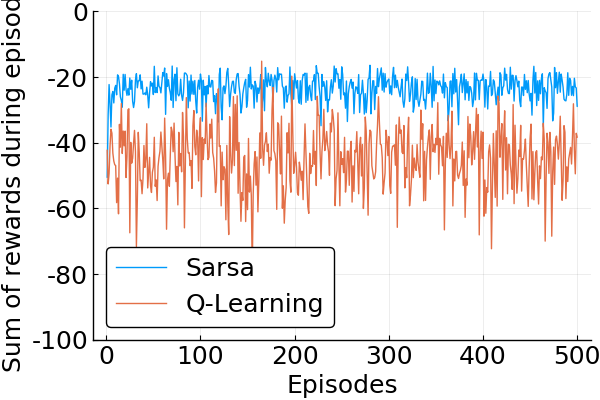

In [211]:
figure_6_4(mdp, episodes,EPSILON,ALPHA,GAMMA,50)